# Time Series Analysis & Data Preparation 

Time series analysis is one of the most common types of data analysis, as it pertains to any data/information collected and stored over a period of time. This could be anything such as yearly sales, weekly temperatures, daily energy consumption, or even categorical such as recording the air quality per day! 

Time series analysis is also more complex than typical data anlysis, as you'll need to do a bit of work beforehand to determine the best course of action in our analysis - certain methods are dependant on the data having particular qualities! First let's start off with exploring some time series data, getting aquainted with the structure, and some basic transformations. 

## Bringing in some data

We will set up our workspace and bring in some data on Stack Overflow question topics, found [here](https://www.kaggle.com/datasets/aishu200023/stackindex?resource=download). This data contains columns: 

- `month`: the month over which question topics were summed 
- `python`: the number of questions on stack overflow pertaining to python 
- `r`: the number of questions on stack overflow pertaining to r
- `numpy`: the number of questions on stack overflow pertaining to numpy
- `scipy`: the number of questions on stack overflow pertaining to scipy

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

In [32]:
so = pd.read_csv('stack_overflow.csv')
so.head()

,month,python,r,numpy,scipy
0,09-Jan,631.0,8.0,6,2.0
1,09-Feb,633.0,9.0,7,NaN
2,09-Mar,766.0,4.0,4,2.0
3,09-Apr,768.0,12.0,6,3.0
4,09-May,NaN,NaN,7,2.0


## Basic exploration 

It is always a good idea to start off with some basic data exploration, similar to how you'd work with any other data type. This includes things like getting an overview of the data & values, and searching for any missing data, and even some cursory visualizations. 

Let's start by checking the data types of each column. 

In [33]:
so.dtypes

month      object
python    float64
r         float64
numpy       int64
scipy     float64
dtype: object

We see that most columns are of numeric value type, whether it be float64 or int64. However, `month`, which indicates our date, is an object! Rather than a string, we want this to be in **datetime** format as that will communicate to pandas that this is time series data & will open up the use of some handy time transformations. 

We can use `pd.to_datetime()` to achieve this, inputting the column to be converted and the `format` of the string-type date. We need to communicate the format of our date string to pandas using **strftime abbreviations** so it can properly convert it. Our date is in a format such as `09-Jan`, where the first value abbreviated year (`%y`) and the second value is the abbreviated month name (`%b`). So for format we input `%y-%b`. 

[Here](https://www.geeksforgeeks.org/python-strftime-function/) is a helpful key for all the strftime abbreviations for translating these formats! 

In [34]:
so['month'] =  pd.to_datetime(so['month'], format = '%y-%b')
so.head()

,month,python,r,numpy,scipy
0,2009-01-01,631.0,8.0,6,2.0
1,2009-02-01,633.0,9.0,7,NaN
2,2009-03-01,766.0,4.0,4,2.0
3,2009-04-01,768.0,12.0,6,3.0
4,2009-05-01,NaN,NaN,7,2.0


In [35]:
so.dtypes

month     datetime64[ns]
python           float64
r                float64
numpy              int64
scipy            float64
dtype: object

See that the column type & value have been converted! 

Now we can use `describe` to get an idea of what values are in each column.  

In [36]:
so.describe()

,python,r,numpy,scipy
count,125.000000,128.000000,132.000000,129.000000
mean,10009.384000,2437.539062,514.204545,113.968992
std,6236.607129,1714.422255,392.882978,69.268041
min,631.000000,4.000000,4.000000,2.000000
25%,3763.000000,612.000000,119.000000,44.000000
50%,9892.000000,2639.000000,486.000000,133.000000
75%,15752.000000,4009.250000,901.500000,172.000000
max,23602.000000,5138.000000,1310.000000,229.000000


We can easily check for missing values in a column or all columns using `isna()`. Recall that `NaN` values are 'not a number' and act as fill values when there is data missing (see [here](https://towardsdatascience.com/5-methods-to-check-for-nan-values-in-in-python-3f21ddd17eed) for a refresher if needed). 

Using `isna()` alone returns a boolean dataframe telling us which cells satisfy the condition of containing `NaN`. Chaining `sum()` to it provides a count of the number of `NaN` values in each column! 

In [37]:
so.isna().sum()

month     0
python    7
r         4
numpy     0
scipy     3
dtype: int64

Here we see that the `python` column is missing 7 values (contains 7 `NaN` values), `r` is missing 4, and `scipy` is missing 3. The `month` and `numpy` columns have no missing values. 

Visualization is especially important in time series analysis as our eye is often pretty good at picking out broad trends. Let's use **matplotlib** to create a basic time series plot with time on the x axis, and the count of questions on each topic/package on the y axis. 

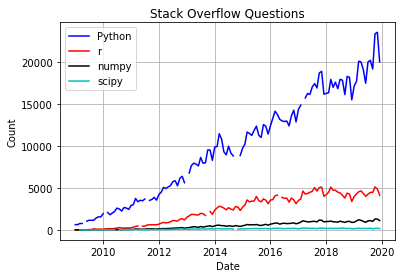

In [38]:
plt.plot(so.month, so.python, c = 'b', label = 'Python')
plt.plot(so.month, so.r, c = 'r', label = 'r')
plt.plot(so.month, so.numpy, c = 'k', label = 'numpy')
plt.plot(so.month, so.scipy, c = 'c', label = 'scipy')

plt.title('Stack Overflow Questions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(which = 'major')

Great! We can see that by far python has the biggest growth in questions over time & the most questions asked overall. R experiences growth over time, but not nearly as much as python. Numpy and scipy have a small amount of questions and minimal growth over time. 

You can also see that there are some gaps in the data where we identified `NaN` values! This is shown as a break in the line & is most obvious for python around 2013, 2015 and 2017. 

## Filling missing values 

### Don't use mean filling! 
Before proceeding we want to fill any missing data with a meaningful value. In other words, we want to figure out what value we can replace any `NaN` values with. It is common to fill missing data with a mean or median values, but this is **not** recommended with time series data! We will demonstrate why mean-filling is not a good approach with time series data & demonstrate some useful alternatives.

Let's create a new dataframe called `python` that only contains the `month` and `python` column from `so`. We will also add a new column called `meanfill` in which we use `fillna` to replace all `NaN` values with the mean of the original `python` column. 

In [39]:
py = so[['month', 'python']]
py['meanfill'] = py['python'].fillna(py['python'].mean())
py.head()

<ipython-input-39-ce31e895eba2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  py['meanfill'] = py['python'].fillna(py['python'].mean())


,month,python,meanfill
0,2009-01-01,631.0,631.000
1,2009-02-01,633.0,633.000
2,2009-03-01,766.0,766.000
3,2009-04-01,768.0,768.000
4,2009-05-01,NaN,10009.384


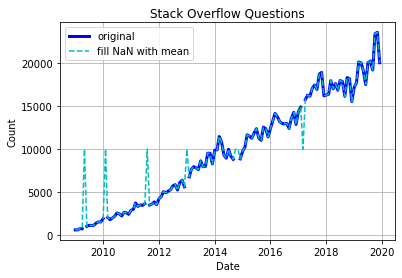

In [40]:
plt.plot(py.month, py.python, c = 'b', linewidth = 3, label = 'original')
plt.plot(py.month, py.meanfill, c = 'c', linestyle = '--', label = 'fill NaN with mean')

plt.title('Stack Overflow Questions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(which = 'major')

The above plot shows the original data in blue & the mean filled data in red. See how the filled values jump out! This is **not** a good method for filling values as time series data tends to grow/shrink over time in such a way that the mean value is not representative of the data at various points in time. 

### Interpolating values 

The suggested method for filling values in a time series is using interpolation, which can be done using the pandas **`interpolate`** function ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)). Rather than hard-coding the value like we did with `fillna`, `interpolate` uses the values surrounding the missing value to guess a reasonable fill value. 

There are a variety of methods that can be used, the default being **`linear`** which according to the documentation ignores the data's index and treats the values as equally spaced. 

Let's add a column to our `python` dataframe containing linearly interpolated values & see how that compares to our mean-fill method. As a note, since we do not have any consecutive `NaN` values we do not need to specify the `fill direction` parameter. We also do not need to set the `limit` paramter which indicates the maximum number of consecutive `NaN`s to fill - this is so we do not fill long stretches of time with missing data, which tends to not be best practice. 

In [41]:
py['linear'] = py['python'].interpolate(method ='linear')

<ipython-input-41-5cd1109cf943>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  py['linear'] = py['python'].interpolate(method ='linear')


Another method we will demonstrate is **`pad`** which uses existing values to fill the gaps. `pad` works with a forward `limit_direction`, which means that a missing value will take on the value of that which came before it. 

In [42]:
py['padded'] = py['python'].interpolate(method ='pad')

Let's add all these to a plot and do a quick eyeball analysis to see which performed best. 

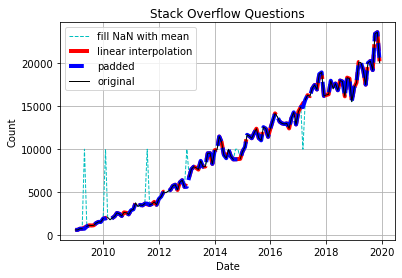

In [43]:
plt.plot(py.month, py.meanfill, c = 'c', linestyle = '--', linewidth = 1, label = 'fill NaN with mean')
plt.plot(py.month, py.linear, c = 'r', linestyle = '-.', linewidth = 4, label = 'linear interpolation')
plt.plot(py.month, py.padded, c = 'b', linestyle = '--', linewidth = 4, label = 'padded')
plt.plot(py.month, py.python, c = 'k', linewidth = 1, label = 'original')

plt.title('Stack Overflow Questions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(which = 'major')

In [44]:
py.iloc[0:10]

,month,python,meanfill,linear,padded
0,2009-01-01,631.0,631.000,631.0,631.0
1,2009-02-01,633.0,633.000,633.0,633.0
2,2009-03-01,766.0,766.000,766.0,766.0
3,2009-04-01,768.0,768.000,768.0,768.0
4,2009-05-01,NaN,10009.384,907.0,768.0
5,2009-06-01,1046.0,1046.000,1046.0,1046.0
6,2009-07-01,1165.0,1165.000,1165.0,1165.0
7,2009-08-01,1143.0,1143.000,1143.0,1143.0
8,2009-09-01,1169.0,1169.000,1169.0,1169.0
9,2009-10-01,1424.0,1424.000,1424.0,1424.0


As mentioned previously the mean fill method is clearly not the best choice. You can see that there is little discernable visual difference between the linear interpolation & the padded fill values. Both of these seem to be good options and fit in reasonably well with the original data. 

Looking at the fill values themselves (see index 4), you can see that the padded interpolation value repeats the 768 value from index 3 to fill the missing value at 4. The linear interpolated value picks a value halfway between index 3 and 5 (values 768 and 1046) to fill the position at value 4 with 907. 

Exactly which method you use (linear interpolation, padding, or any other method available in the function) will have to be determined on a case by case basis depending on the data but these two are the most common & tend to be reliable in most cases. 

<hr style="border:2px solid gray"> </hr>

### Now you try! 

Fill the missing values from the `r` column in our `so` dataframe with using linear interpolation. Name the new column in `so` `r_interp`. Plot the original and filled versions together. 

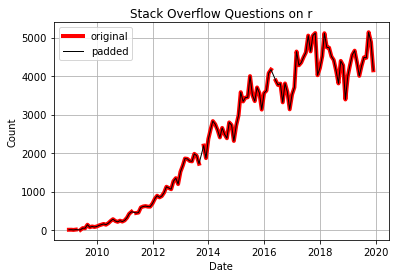

In [45]:
### BEGIN SOLUTION 

so['r_interp'] = so['r'].interpolate(method = 'linear')

plt.plot(so.month, so.r, c = 'r', linestyle = '-', linewidth = 4, label = 'original')
plt.plot(so.month, so.r_interp, c = 'k', linewidth = 1, label = 'padded')

plt.title('Stack Overflow Questions on r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(which = 'major')

### END SOLUTION 

<hr style="border:2px solid gray"> </hr>

## Resampling 

Another useful transformation for time series data is **resampling**. This means transforming the data frequency from finer to coarser - e.g. from daily data to weekly or monthly data. This can be achieved using pandas' `resample` function ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)). 

We have yearly stack overflow question frequency on 'matlab' in the file `matlab_yearly.csv`. This contains the total number of questions asked about matlab **per year**. 

In [46]:
matlab = pd.read_csv('matlab_yearly.csv')
matlab['year'] = pd.to_datetime(matlab['year'], format = '%Y')
matlab.head()

,year,matlab
0,2009-01-01,599
1,2010-01-01,1822
2,2011-01-01,3934
3,2012-01-01,7268
4,2013-01-01,11712


Say we want to compare this to our question frequency from the `r` column of our `so` dataframe to the yearly matlab values. We can try plotting them together, such as below, but the matlab data shows yearly sums, which is not readily comparable to the monthly sums shown for R! 

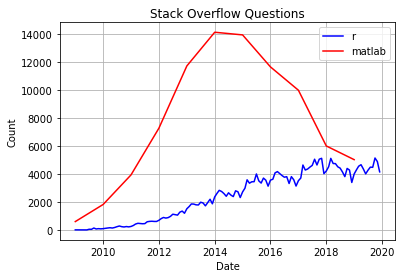

In [47]:
plt.plot(so.month, so.r_interp, c = 'b', label = 'r')
plt.plot(matlab.year, matlab.matlab, c = 'r', label = 'matlab')

plt.title('Stack Overflow Questions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(which = 'major')

Let's **resample** the `r_filled` column to show **yearly totals** rather than monthly values. 

We accomplish this usin `df.resample()` inputting a `freq` or frequency of `Y`, for year. Other `freq` inputs are possible such as `M` for monthly, `D` for daily, `3Y` for 3 yearly, but it must always be making the data **coarser**, not finer! 

We compute a summary value over the given time period by applying an operation like `sum` or `mean` to translate the monthly values into yearly values. In this case we will use `sum` to match the matlab data. 

For this to work, the index of the dataframe must be our datetime column, so we will apply that using `set_index`. 

In [57]:
r = so[['month', 'r_interp']]

r.set_index('month', inplace = True)
r_yearly = r.resample('Y').sum()
r_yearly.head()

,r_interp
month,
2009-12-31,530.5
2010-12-31,2266.0
2011-12-31,5870.0
2012-12-31,12195.0
2013-12-31,22134.5


You'll notice that in addition to the number of rows changing & the values now reflecting yarly totals, the index has changed as well. The index column called `month` now shows the last day of each year. Resampling will change your timestamp value in such a way that it reflects the **end** of the resampling period. 

You'll also notice that the headers are offset above the `month` column label. This is because resampling creates what is called a **multiindex**. We can do away with this for now by using `reset_index`. We will also rename the `month` column to `year`. 

In [58]:
r_yearly.reset_index(inplace = True)
r_yearly.rename(columns = {'month': 'year'}, inplace = True)
r_yearly.head()

,year,r_interp
0,2009-12-31,530.5
1,2010-12-31,2266.0
2,2011-12-31,5870.0
3,2012-12-31,12195.0
4,2013-12-31,22134.5


We are almost ready to make a comparison! One last thing stands in our way - the year index in `r_yearly` reflects that last day in the year, while the year in `matlab` reflects the first day of the year. We ideally want the two times to be the same. 

We can fix this in a number of ways, one being to just reset the `r_yearly` index with the `matlab` values

        r_yearly.set_index(matlab.year, inplace = True)


However, this only works if the time frame of the two datasets is identical. In this case it will work, but it's not the most reliable method! It would be better to implement a **time offset**. This is a method implemented after resampling to adjust back to the middle of the timeframe.  We can import `to_offset` from the `tseries.frequencies` pandas package which will allow us to do this. 

Let's make the `r_yearly` dates match those from `matlab` by subtracting 364 days. We will set our `loffset` to `364D` to indicate this. We will subtract this offset from our `year` column to create a new column, `year_offset`. This will transform our date from last day of the year to the first day of the year. It will be off by a day for leap years, but we will ignore that for now. 

In [63]:
from pandas.tseries.frequencies import to_offset

loffset = '364D'
r_yearly['year_offset'] = r_yearly['year'] - to_offset(loffset)
r_yearly.head()

,year,r_interp,year_offset
0,2009-12-31,530.5,2009-01-01
1,2010-12-31,2266.0,2010-01-01
2,2011-12-31,5870.0,2011-01-01
3,2012-12-31,12195.0,2012-01-02
4,2013-12-31,22134.5,2013-01-01


Now we can finally make a meaningful comparison! Let's plot the yearly `matlab` data alongside the new yearly `r_yearly` data. Remember we have to use the `year_offset` column we created as our x axis variable so it matches the matlab time frequency! 

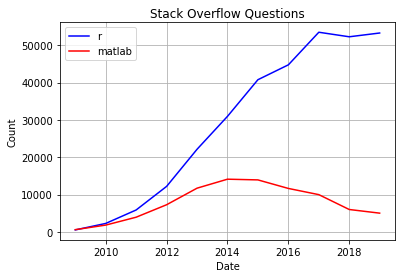

In [64]:
plt.plot(r_yearly.year_offset, r_yearly.r_interp, c = 'b', label = 'r')
plt.plot(matlab.year, matlab.matlab, c = 'r', label = 'matlab')

plt.title('Stack Overflow Questions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(which = 'major')

Great, now we can meaningfully compare the two. It looks like matlab questions peaked in popularity in 2014-2015 and had steadily declined since then. In contrast, R seems to have greatly climbed in popularity until around 2017 when it began to level off. 

## Moving averages 

Finally, 

<hr style="border:2px solid gray"> </hr>

# Practice on your own 

#### Exercise 1. 